In [48]:
# future functions
from __future__ import print_function 

# core scipy and numpy
import numpy as np
import scipy as sp

# pandas 
import pandas as pd
from IPython.display import display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 135

# encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# manifold for embedding analysis
from sklearn import manifold

# Cross validation 
from sklearn.model_selection import KFold

# Linear models 
from sklearn import linear_model

# Forests
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# SVR
from sklearn.svm import SVR

# KNN
from sklearn.neighbors import KNeighborsRegressor

# PCA
from sklearn.decomposition import PCA, FastICA

# vowpal wabbit
from vowpalwabbit.sklearn_vw import VWRegressor

# combinations with categorical features
from itertools import combinations

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn 
import seaborn as sns 

# python helpers 
from collections import namedtuple
from copy import deepcopy, copy

# neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Merge, Reshape
from keras.layers.embeddings import Embedding

# XGboost for gradient-boosted decision trees
import xgboost as xgb

# regular expressions 
import re

# logging
import logging
logging.basicConfig()

#### Custom functions

In [49]:
loadfile = lambda x: pd.read_csv(x, index_col=0)

# check column data for skew 
get_skew = lambda x: sp.stats.skewtest(x.dropna())>0.75

#### Wrapper functions

In [50]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=2, params={}):
        try:
            params['random_state'] = seed
            self.clf = clf(**params)
        except:
            del params['random_state'] 
            self.clf = clf(**params)

    def train(self, x_train, y_train):
        xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        self.clf.fit(xtr, ytr)

    def predict(self, x):
        xte = preprocessing_X(x)
        return self.clf.predict(xte)


class XgbWrapper:
    def __init__(self,  seed=2, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        dtrain = xgb.DMatrix(xtr, label=ytr)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        xte = preprocessing_X(x)
        return self.gbdt.predict(xgb.DMatrix(xte))


class NnWrapper:
    def __init__(self, model, emb=True, nb_epoch=16, batch_size=8):
        self.model = model
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.emb = emb
    
    def train(self, x_train, y_train):
        if self.emb:
            xtr = nn_preprocessing_X(x_train)
        else:
            xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        self.model.fit(xtr, ytr, 
                 nb_epoch = self.nb_epoch,
                 batch_size = self.batch_size,
                 verbose = 0)
    
    def predict(self, x):
        if self.emb:
            xte = nn_preprocessing_X(x)
        else:
            xte = preprocessing_X(x)
        return self.model.predict(xte).ravel()


def get_oof(clf):
    '''
        via:
        https://www.kaggle.com/eliotbarr/house-prices-
        advanced-regression-techniques/stacking-starter/code
    '''
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


get_rmse = lambda x,y: np.sqrt(np.mean(((x.ravel()*max_y) - np.log(y.ravel()+1))**2))

#### Custom objects

In [51]:
Files = namedtuple('Files',['train','test'])
RawData = namedtuple('RawData',['train','test'])
ProcessedData = namedtuple('ProcessedData',['x_train','y_train','test'])

#### Load data 

In [52]:
# load raw data
rawfiles = Files(train='Data/train.csv.gz',
            test='Data/test.csv.gz')
raw = RawData(train=loadfile(rawfiles.train),
              test=loadfile(rawfiles.test))

In [53]:
# concatenate all data 
cols = [ c for c in raw.train.columns if c != 'SalePrice' ]
full = pd.concat((raw.train.loc[:, cols],
                     raw.test))

#### analyze full dataset

In [54]:
full.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,NaN,7478.000000,5.000000,5.000000,1953.500000,1965.000000,NaN,NaN,NaN,NaN,NaN,876.000000,0.000000,0.000000,1126.000000,NaN,NaN,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,NaN,9453.000000,6.000000,5.000000,1973.000000,1993.000000,NaN,NaN,NaN,NaN,NaN,1082.000000,0.000000,0.000000,1444.000000,NaN,NaN,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,NaN,NaN,NaN,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,NaN,11570.000000,7.000000,6.000000,2001.000000,2004.000000,NaN,NaN,NaN,NaN,NaN,1387.500000,704.000000,0.000000,1743.500000,NaN,NaN,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,NaN,NaN,NaN,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


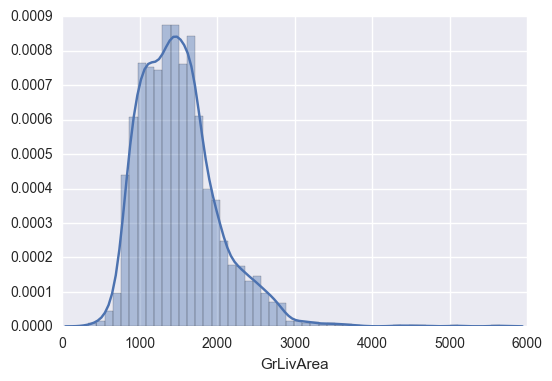

In [55]:
sns.distplot(full.GrLivArea.dropna())

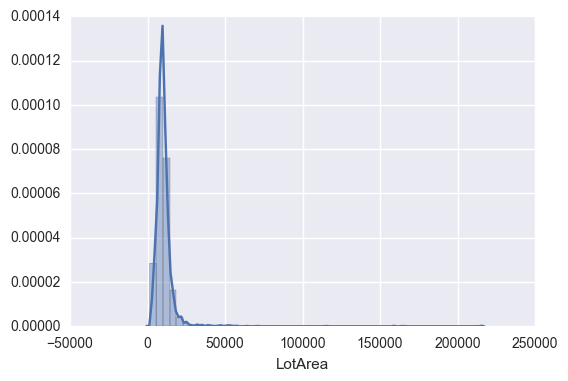

In [56]:
sns.distplot(full.LotArea.dropna())

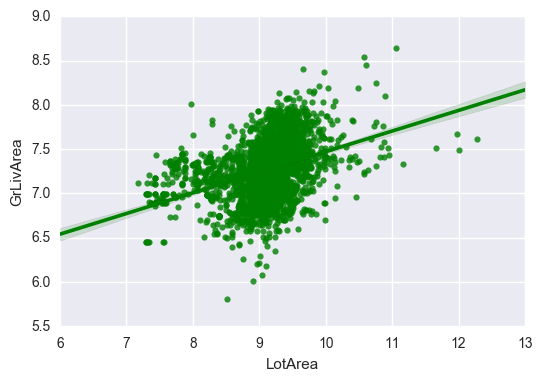

In [57]:
sns.regplot(np.log1p(full.LotArea), np.log1p(full.GrLivArea), color='g', ci=95)

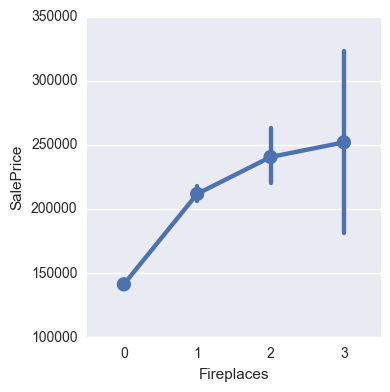

In [58]:
sns.factorplot(x='Fireplaces', y='SalePrice', data=raw.train)

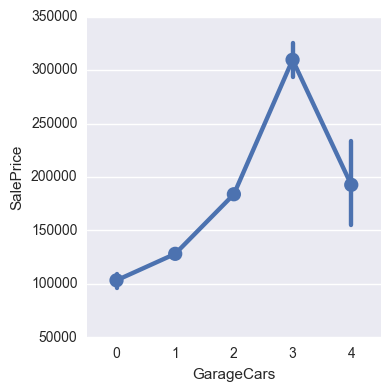

In [59]:
sns.factorplot(x='GarageCars', y='SalePrice', data=raw.train)

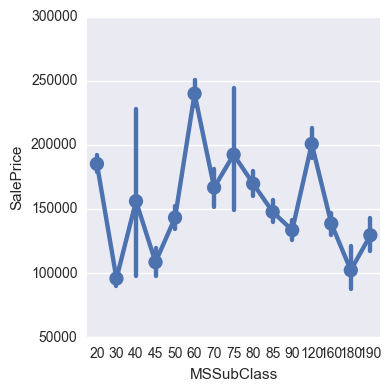

In [60]:
sns.factorplot(x='MSSubClass', y='SalePrice', data=raw.train)

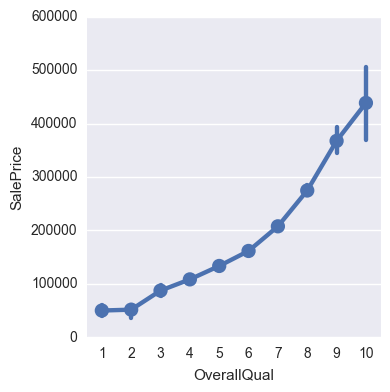

In [61]:
sns.factorplot(x='OverallQual',y='SalePrice',data=raw.train)

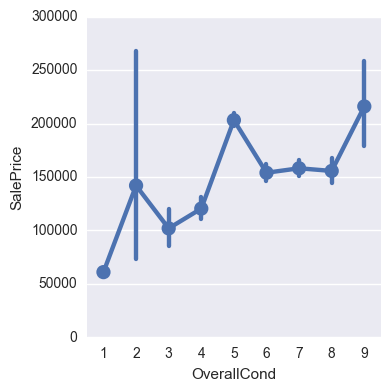

In [62]:
sns.factorplot(x='OverallCond',y='SalePrice',data=raw.train)

### Data processing / cleansing

In [63]:
full.shape

(2919, 79)

#### Categorical & numeric columns

In [64]:
# create lookup for numeric categorical columns
numeric_categorical = [
    'MSSubClass',
    'YearBuilt',
    'YearRemodAdd',
    'MoSold',
    'YrSold',
    'GarageYrBlt',
    'OverallQual',
    'OverallCond',
    'MiscVal',
    'GarageCars',
    'Fireplaces',
]

# drop calls from feature importance analysis
dropcols = ['3SsnPorch',
             'BsmtCond',
             'BsmtFinSF2',
             'BsmtFinType2',
             'BsmtHalfBath',
             'Condition1',
             'Condition2',
             'EnclosedPorch',
             'Functional',
             'GarageCond',
             'GarageQual',
             'LotConfig',
             'LowQualFinSF',
             'MiscVal',
             'MoSold',
             'PoolArea',
             'RoofMatl',
             'Street',
             'Utilities',
             'YearBuilt',
             'YrSold',
           ]

# categorical column list
categorical_cols = list(full.dtypes[full.dtypes == "object"].index)
categorical_cols += numeric_categorical
categorical_cols = [ c for c in categorical_cols if c not in dropcols ]

# continuous column list
continuous_cols = list(full.dtypes[full.dtypes != "object"].index)
continuous_cols = [ c for c in continuous_cols 
                       if c not in numeric_categorical 
                       and c!='SalePrice' 
                       and c not in dropcols ]

#### Create new columns

In [65]:
@np.vectorize
def cnt_categorize_3(x):
    if x==0:
        return '0'
    elif x==1:
        return '1'
    elif x>1:
        return '2+'
    else:
        return x

@np.vectorize
def categorize_3(x, s1, s2):
    if x<s1:
        return '0'
    elif x>=s1 and x<s2:
        return '1'
    else:
        return '2'

@np.vectorize
def categorize_4(x, s1, s2, s3):
    if x<s1:
        return '0'
    elif x>=s1 and x<s2:
        return '1'
    elif x>=s2 and x<s3:
        return '2'
    else:
        return '3'

@np.vectorize
def categorize_bin(x, s):
    if x<s:
        return 0
    else:
        return 1


In [66]:
full.loc[:,continuous_cols].describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch
count,2433.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000
mean,69.305795,10168.114080,102.201312,441.423235,560.772104,1051.777587,1159.581706,336.483727,1500.759849,0.429894,1.568003,0.380267,2.860226,1.044536,6.451524,472.874572,93.709832,47.486811,16.062350
std,23.344905,7886.996359,179.334253,455.610826,439.543659,440.766258,392.362079,428.701456,506.051045,0.524736,0.552969,0.502872,0.822693,0.214462,1.569379,215.394815,126.526589,67.575493,56.184365
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,7478.000000,NaN,NaN,NaN,NaN,876.000000,0.000000,1126.000000,NaN,1.000000,0.000000,2.000000,1.000000,5.000000,NaN,0.000000,0.000000,0.000000
50%,NaN,9453.000000,NaN,NaN,NaN,NaN,1082.000000,0.000000,1444.000000,NaN,2.000000,0.000000,3.000000,1.000000,6.000000,NaN,0.000000,26.000000,0.000000
75%,NaN,11570.000000,NaN,NaN,NaN,NaN,1387.500000,704.000000,1743.500000,NaN,2.000000,1.000000,3.000000,1.000000,7.000000,NaN,168.000000,70.000000,0.000000
max,313.000000,215245.000000,1600.000000,5644.000000,2336.000000,6110.000000,5095.000000,2065.000000,5642.000000,3.000000,4.000000,2.000000,8.000000,3.000000,15.000000,1488.000000,1424.000000,742.000000,576.000000


In [67]:
# before 2009 flag 
full['Before2009'] = full.YrSold < 2009
categorical_cols += ['Before2009']

# quarter of year sold
full['QtrOfYearSold'] = full.MoSold.apply(lambda x: categorize_4(x, 4, 7, 10))
categorical_cols += ['QtrOfYearSold']

# percent of lot
full['PctOfLot'] = full.GrLivArea / full.LotArea
continuous_cols += ['PctOfLot']

# percent first floor of total
full['Pct1stFlr'] = full['1stFlrSF'] / full.GrLivArea
continuous_cols += ['Pct1stFlr']

# percent second floor of total
full['Pct2ndFlr'] = full['2ndFlrSF'] / full.GrLivArea
continuous_cols += ['Pct2ndFlr']

# percent basement of total
full['PctBasement'] = full.TotalBsmtSF / full.GrLivArea
continuous_cols += ['PctBasement']

# 2nd floor / 1st floor ratio
full['2nd1stRatio'] = full['2ndFlrSF'] / full['1stFlrSF']
continuous_cols += ['2nd1stRatio']

# Bathrooms per SF
full['BathPerSF'] = (full.FullBath+0.5*full.HalfBath+full.BsmtFullBath) / full.GrLivArea
continuous_cols += ['BathPerSF']

# Bedrooms per SF
full['BedroomPerSF'] = full.BedroomAbvGr / full.GrLivArea
continuous_cols += ['BedroomPerSF']

# Total rooms per SF
full['TotalRoomsPerSF'] = full.TotRmsAbvGrd / full.GrLivArea
continuous_cols += ['TotalRoomsPerSF']

# percent size of garage
full['PctGarage'] = full.GarageArea / full.GrLivArea
continuous_cols += ['PctGarage']

# ratio garage cars to area
full['GarageCarRatio'] = full.GarageCars / full.GarageArea
continuous_cols += ['GarageCarRatio']

# Frontage percent of lot area
full['FrontagePctArea'] = full.LotFrontage / full.LotArea
continuous_cols += ['FrontagePctArea']

#### Add PCA columns

In [68]:
# PCA overall quality 
pca_components = 6
pca_cols = map(lambda x: 'PCA_Qual_'+str(x), range(pca_components))
pca_qual = PCA(n_components=pca_components)
X = pd.get_dummies(full.OverallQual)
Xt = pca_qual.fit_transform(X)
Xt_df = pd.DataFrame(Xt, columns=pca_cols, index=full.index)
full = pd.concat((full, Xt_df),axis=1)
continuous_cols += pca_cols

# PCA overall condition 
pca_components = 3
pca_cols = map(lambda x: 'PCA_Cond_'+str(x), range(pca_components))
pca_cond = PCA(n_components=pca_components)
X = pd.get_dummies(full.OverallCond)
Xt = pca_cond.fit_transform(X)
Xt_df = pd.DataFrame(Xt, columns=pca_cols, index=full.index)
full = pd.concat((full, Xt_df),axis=1)
continuous_cols += pca_cols

# PCA year sold
pca_components = 3
pca_cols = map(lambda x: 'PCA_YrSold_'+str(x), range(pca_components))
pca_yrsold = PCA(n_components=pca_components)
X = pd.get_dummies(full.YrSold)
Xt = pca_yrsold.fit_transform(X)
Xt_df = pd.DataFrame(Xt, columns=pca_cols, index=full.index)
full = pd.concat((full, Xt_df),axis=1)
continuous_cols += pca_cols

#### Specific category embeddings

In [69]:
# year built embedding model
m = full.YearBuilt.value_counts().shape[0]
new_m = 3
np.random.seed(22)
le = LabelEncoder()
le.fit(full.YearBuilt)
Xtr = raw.train.YearBuilt.as_matrix()
Xtr = le.transform(Xtr)
ytr = np.log1p(raw.train.SalePrice).as_matrix()
ytr = ytr / np.max(ytr)
models = []
emb_model = Sequential()
emb_model.add(Embedding(m, new_m, input_length=1))
emb_model.add(Reshape(target_shape=(new_m,)))
emb_model.add(Dropout(0.01))
emb_model.add(Dense(128, init='uniform'))
emb_model.add(Activation('relu'))
emb_model.add(Dropout(0.2))
emb_model.add(Dense(64, init='uniform'))
emb_model.add(Activation('relu'))
emb_model.add(Dropout(0.2))
emb_model.add(Dense(1))
emb_model.add(Activation('sigmoid'))
emb_model.compile(loss='mean_squared_error', optimizer='adam')
emb_model.fit(Xtr, ytr, 
                 nb_epoch = 10,
                 batch_size = 16,
                 verbose = 0)
X = le.transform(full.YearBuilt)
Xohe = OneHotEncoder().fit_transform(X.reshape(-1,1)).A
w =  emb_model.get_weights()[0]
Xemb = np.dot(Xohe, w)
Xemb_cols = map(lambda x: 'YrBuilt_Emb_Col_'+str(x), range(new_m))
Xemb_df = pd.DataFrame(Xemb, columns=Xemb_cols, index=full.index)
full = pd.concat((full, Xemb_df), axis=1)
continuous_cols += Xemb_cols

#### imputing, log-transforms, encoding

In [70]:
n, m = full.shape

# store important objects
label_encoders = {}
categorical_col_nums = []

# loop through columns and delete crap columns
for col, col_data in full.iteritems():
    
    # count the nulls
    nans = np.sum(col_data.isnull())
    if nans*1.0 / n > 0.2:
        
        # drop columns that suck
        del full[col]
        if col in categorical_cols:
            categorical_cols.remove(col)
        elif col in continuous_cols:    
            continuous_cols.remove(col)
        if col in numeric_categorical:
            numeric_categorical.remove(col)
    
    if col in dropcols:
        if col in full.columns:
            del full[col]


# second loop through columns to process data 
for col, col_data in full.iteritems():
    
    # handle categorical data
    if col_data.dtype == object or col in numeric_categorical:
        
        # impute missing values 
        col_data = col_data.fillna(col_data.value_counts().index[0])
        
        # categorize columns 
        if col in ['GarageCars','Fireplaces']:
            col_data = col_data.apply( cnt_categorize_3 )
        
#         if col in ['OverallCond']:
#             col_data = col_data.apply(lambda x: categorize_4(x, 3, 5, 6))

        # encode categorical values
        le = LabelEncoder()
        col_data = le.fit_transform(col_data)
        categorical_col_nums.append(full.columns.get_loc(col))
        label_encoders[col] = le

        # store column 
        full.loc[:, col] = col_data

    # handle numeric data
    else:

        # check skew 
        if get_skew(full[col]):
            full.loc[:, col] = np.log1p(full[col])
            full.loc[:, col] = np.log1p(full[col])

        # handle nulls 
        nans = np.sum(col_data.isnull())
        if nans>0:
            full.loc[:, col] = full[col].fillna(np.mean(full[col].dropna()))

#### Setup standard scaler and one hot encoder

In [71]:
# standard scaler
continous_scaler = StandardScaler()
c = continous_scaler.fit_transform(full.loc[:, continuous_cols].as_matrix())

# minmax 
mm_scaler = MinMaxScaler(feature_range=(-1, 1))
m = mm_scaler.fit_transform(c)

# transform data in full dataset
full.loc[:, continuous_cols] = m 

# create one hot encoder
ohe = OneHotEncoder(categorical_features=categorical_col_nums)
o = ohe.fit_transform(full.as_matrix())

# pca for ohe columns
pca_ohe_n = 1
pca_ohe = PCA(n_components=pca_ohe_n)
_ = pca_ohe.fit(o.A)

#### Processed dataset

In [72]:
# create processed dataset
train = full.loc[ raw.train.index, :]
test = full.loc[ raw.test.index, :] 
processed = ProcessedData( x_train = train ,
                           y_train = raw.train.SalePrice ,
                           test = test )
processed.x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,SaleType,SaleCondition,Before2009,QtrOfYearSold,PctOfLot,Pct1stFlr,Pct2ndFlr,PctBasement,2nd1stRatio,BathPerSF,BedroomPerSF,TotalRoomsPerSF,PctGarage,GarageCarRatio,FrontagePctArea,PCA_Qual_0,PCA_Qual_1,PCA_Qual_2,PCA_Qual_3,PCA_Qual_4,PCA_Qual_5,PCA_Cond_0,PCA_Cond_1,PCA_Cond_2,PCA_YrSold_0,PCA_YrSold_1,PCA_YrSold_2,YrBuilt_Emb_Col_0,YrBuilt_Emb_Col_1,YrBuilt_Emb_Col_2
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,-0.049771,-0.150812,3,3,0,5,0,5,6,4,53,1,12,13,1,0.729236,2,4,2,2,3,2,0.785715,0.654186,0.801380,1,0,1,4,-0.231546,0.899983,0.237589,0.210909,0.545719,0.420763,0.496609,0.210909,2,0.435695,0,1,94,1,2,0.879093,2,-1.000000,0.610744,-1.0,8,4,0.526855,0,-0.396871,-0.161213,0.540038,-0.074541,0.227008,-0.295660,-0.167077,-0.113221,-0.218790,-0.420574,-0.605100,-1.000000,1.00000,-1.000000,-0.179132,-0.556799,-0.599519,-1.000000,0.569733,-0.315175,-0.191939,-1.000000,-0.400104,0.135312,-0.234330,0.562786
2,0,3,0.104840,-0.098820,3,3,0,24,0,2,5,7,26,1,8,8,2,-1.000000,3,4,1,2,1,0,0.822919,0.746688,0.844306,1,0,1,4,0.058886,-1.000000,0.026408,-1.000000,0.545719,-1.000000,0.496609,0.210909,3,0.156522,1,1,67,1,2,0.856234,2,0.801593,-1.000000,-1.0,8,4,0.526855,1,-0.595768,1.000000,-1.000000,0.430626,-1.000000,-0.499041,0.127903,-0.089992,-0.138073,-0.263512,-0.569187,-0.086075,-1.00000,-0.539098,-0.127429,-0.534472,-0.591417,0.794771,0.718914,1.000000,1.000000,0.602212,-0.889882,0.545207,0.182820,0.250328
3,5,3,-0.015700,-0.035094,0,3,0,5,0,5,6,4,52,1,12,13,1,0.700430,2,4,2,2,2,2,0.741087,0.803491,0.809512,1,0,1,4,-0.176525,0.901650,0.267197,0.210909,0.545719,0.420763,0.496609,0.210909,2,0.156522,1,1,92,1,2,0.892407,2,-1.000000,0.537776,-1.0,8,4,0.526855,2,-0.516508,-0.118545,0.508539,-0.055979,0.187207,-0.333987,-0.202461,-0.516914,-0.181623,-0.501679,-0.697631,-1.000000,1.00000,-1.000000,-0.179132,-0.556799,-0.599519,-1.000000,0.569733,-0.315175,-0.191939,-1.000000,-0.400104,-0.005975,-0.403368,0.374065
4,6,3,-0.110878,-0.100935,0,3,0,6,0,5,6,4,20,1,13,15,2,-1.000000,3,4,0,3,3,0,0.635783,0.831471,0.787191,1,2,1,4,-0.143497,0.885296,0.240377,0.210909,0.098050,-1.000000,0.496609,0.210909,2,0.307695,1,5,89,2,2,0.899306,2,-1.000000,0.500297,-1.0,8,0,0.526855,0,-0.457778,0.008101,0.408518,-0.154954,0.067779,-0.684081,-0.170467,-0.297194,-0.121423,-0.190460,-0.684232,-1.000000,1.00000,-1.000000,-0.179132,-0.556799,-0.599519,-1.000000,0.569733,-0.315175,-0.159267,-0.498251,1.000000,0.509686,0.708458,0.168665
5,5,3,0.140377,0.058366,0,3,0,15,0,5,7,4,50,1,12,13,1,0.811980,2,4,2,2,0,2,0.776930,0.819133,0.833741,1,0,1,4,-0.012596,0.924698,0.406482,0.210909,0.545719,0.420763,0.650432,0.210909,2,0.546260,1,1,91,1,2,0.932096,2,0.737601,0.669594,-1.0,8,4,0.526855,3,-0.529670,-0.101680,0.495797,-0.048643,0.171420,-0.495707,-0.136060,-0.291761,-0.110144,-0.434333,-0.706285,-0.581786,0.60129,1.000000,-1.000000,-0.685816,-0.637138,-1.000000,0.569733,-0.315175,-0.191939,-1.000000,-0.400104,0.337916,-0.308831,0.301413


#### Check out crap columns

In [73]:
rf = RandomForestRegressor(max_depth=4, n_estimators=1200, bootstrap=False, max_features=0.1)
X = pd.get_dummies(processed.x_train, columns=categorical_cols, dummy_na=False)
y = np.log1p(processed.y_train)
rf.fit(X, y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=4,
           max_features=0.1, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [74]:
def testcol(x):
    cols = [ X.columns.get_loc(c) for c in X.columns if re.match(x,c) ]
    return np.max(rf.feature_importances_[cols]), len(cols)

In [75]:
sorted(dropcols)

['3SsnPorch',
 'BsmtCond',
 'BsmtFinSF2',
 'BsmtFinType2',
 'BsmtHalfBath',
 'Condition1',
 'Condition2',
 'EnclosedPorch',
 'Functional',
 'GarageCond',
 'GarageQual',
 'LotConfig',
 'LowQualFinSF',
 'MiscVal',
 'MoSold',
 'PoolArea',
 'RoofMatl',
 'Street',
 'Utilities',
 'YearBuilt',
 'YrSold']

#### Categorical field analysis

In [76]:
categorical_cols = [ c for c in categorical_cols if c not in dropcols ]

In [77]:
categorical_field_analysis = []
for c in categorical_cols:
    # get pct freq coverage of top value 
    v = full[c].value_counts()
    first_pct = v.iloc[0]*1.0/sum(v)

    # get count of distinct values
    distinct_vals = set(full[c].values)
    d_cnt = len(distinct_vals)

    # calculate logical freq  
    logical_pct = 1.0/d_cnt
        
    # append
    categorical_field_analysis.append((c, first_pct, logical_pct, d_cnt))

categorical_field_analysis = pd.DataFrame(categorical_field_analysis,
                                 columns=['Cat_Col',
                                          'First_Freq',
                                          'Logical_Freq',
                                          'Distinct_Val_Cnt',])

In [78]:
@np.vectorize
def choose_m(freq, n):
    for i in range(1,n+1):
        if freq>=(1-float(i)/n):
            x = i
            break
    return x

In [79]:
categorical_field_analysis['m'] =\
choose_m(categorical_field_analysis.First_Freq,\
categorical_field_analysis.Distinct_Val_Cnt)

In [80]:
display(categorical_field_analysis)

,Cat_Col,First_Freq,Logical_Freq,Distinct_Val_Cnt,m
0,MSZoning,0.777321,0.200000,5,2
1,LotShape,0.636862,0.250000,4,2
2,LandContour,0.898253,0.250000,4,1
3,LandSlope,0.951696,0.333333,3,1
4,Neighborhood,0.151764,0.040000,25,22
5,BldgType,0.830764,0.200000,5,1
6,HouseStyle,0.503940,0.125000,8,4
7,RoofStyle,0.791367,0.166667,6,2
8,Exterior1st,0.351490,0.066667,15,10
9,Exterior2nd,0.347722,0.062500,16,11


#### entity embedding model

In [81]:
def gen_emb_nn_model(seed=2):
    np.random.seed(seed)
    models = []

    for i, vals in categorical_field_analysis.T.iteritems():

        # gather reshaping components
        m = vals.Distinct_Val_Cnt
        new_m = vals.m

        # special cases 
        if vals.Cat_Col == 'YearBuilt':
            new_m = 10
        elif vals.Cat_Col == 'GarageYrBlt':
            new_m = 25
        elif vals.Cat_Col == 'YearRemodAdd':
            new_m = 20
        elif vals.Cat_Col == 'Neighborhood':
            new_m = 10
        
        # create embedding for each feature
        entity_model = Sequential()
        entity_model.add(Embedding(m, new_m, input_length=1))
        entity_model.add(Reshape(target_shape=(new_m,)))
        models.append(entity_model)

    n,m = full[continuous_cols].shape
    continuous_model = Sequential()
    continuous_model.add(Dense(m, input_dim=m))
    models.append(continuous_model)

    emb_model = Sequential()
    emb_model.add(Merge(models, mode='concat'))
    emb_model.add(Dropout(0.01))
    emb_model.add(Dense(64, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.2))
    emb_model.add(Dense(64, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.2))
    emb_model.add(Dense(32, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.01))
    emb_model.add(Dense(1))
    emb_model.add(Activation('sigmoid'))
    emb_model.compile(loss='mean_squared_error', optimizer='adam')
    return copy(emb_model)

#### Vanilla NN

In [43]:
# vanilla NN 
def gen_vanilla_nn(seed=2):
    np.random.seed(seed)
    n, m = preprocessing_X(X_train).shape
    vanilla_nn_model = Sequential()
    vanilla_nn_model.add(Dense(64, init='uniform', input_shape=(m,)))
    vanilla_nn_model.add(Activation('relu'))
    vanilla_nn_model.add(Dropout(0.3))
    vanilla_nn_model.add(Dense(128, init='uniform'))
    vanilla_nn_model.add(Activation('relu'))
    vanilla_nn_model.add(Dropout(0.3))
    vanilla_nn_model.add(Dense(1))
    vanilla_nn_model.add(Activation('sigmoid'))
    vanilla_nn_model.compile(loss='mean_squared_error', optimizer='adam')
    return copy(vanilla_nn_model)

#### Preprocessing functions

In [82]:
_y = np.log1p(processed.y_train)
max_y = np.max(_y)


def nn_preprocessing_X(X_dat):
    X_out = []
    
    # categorical columns
    for c in categorical_cols:
        d = X_dat.loc[:, c].as_matrix()
        X_out.append(d)
    
    # continuous columns
    continuous_dat = X_dat.loc[:, continuous_cols].as_matrix()
    
    X_out.append(continuous_dat)
    return X_out


def preprocessing_X(X_dat):
    X_dat = X_dat.copy()
                             
    # one hot encode 
    X_dat = ohe.transform(X_dat.as_matrix()).A
    
    return X_dat


def preprocessing_Y(y_dat):
    return np.log(y_dat.values+1)/max_y

### Modeling

In [83]:
processed.x_train.shape 

(1460, 81)

In [84]:
ntrain = processed.x_train.shape[0]
ntest = processed.test.shape[0]

In [85]:
# set up training and test data
cols = [ c for c in processed.x_train.columns if c not in dropcols ]
X_train = processed.x_train.loc[:, cols]
y_train = processed.y_train
X_test = processed.test

#### Grid Search

#### Train models

In [ ]:
# Decide which models to run
switchboard = {
    'NNE': False ,
    'NNV': False ,
    'XGB': True ,
    'Other': False ,
}

# set up model arrays 
train_models = []
test_models = []

# seeds 
seeds = np.random.choice(range(100), 10, replace=False)

# loop
for s in seeds:
    ## set up K Folds ##
    NFOLDS = 4
    kf = KFold(n_splits=NFOLDS, 
               shuffle=True, 
               random_state=s)

    ## Categorical embedding NN models ##
    if switchboard['NNE']:
        emb_model = gen_emb_nn_model(seed=s)
        NN = copy(NnWrapper(emb_model, emb=True))
        nn_oof_train, nn_oof_test = get_oof(NN)
        train_models.append(nn_oof_train)
        test_models.append(nn_oof_test)
        logging.warn('NNE score, {}: {:,.4f}'.format(s, get_rmse(nn_oof_train, y_train)))

    ## Vanilla NN models ##
    if switchboard['NNV']:
        vanilla_nn_model = gen_vanilla_nn(seed=s)
        NN2 = copy(NnWrapper(vanilla_nn_model, emb=False))
        nn2_oof_train, nn2_oof_test = get_oof(NN2)
        train_models.append(nn2_oof_train)
        test_models.append(nn2_oof_test)
        logging.warn('NNV score, {}: {:,.4f}'.format(s, get_rmse(nn2_oof_train, y_train)))

    ## XGBoost ##
    if switchboard['XGB']:
        base_xgb_params ={
            'colsample_bytree': 0.9 ,
            'silent': 1 ,
            'subsample': 0.5 ,
            'learning_rate': 0.015 ,
            'objective': 'reg:linear' ,
            'max_depth': 3 ,
            'num_parallel_tree': 1 ,
            'min_child_weight': 1 ,
            'eval_metric': 'rmse' ,
            'nrounds': 3200 ,
        }
        base_xgb_params['seed'] = 2
        XG = copy(XgbWrapper(params=base_xgb_params))
        xgb_oof_train, xgb_oof_test = get_oof(XG)
        train_models.append(xgb_oof_train)
        test_models.append(xgb_oof_test)
        logging.warn('XGB score, {}: {:,.4f}'.format(s, get_rmse(xgb_oof_train, y_train)))

    ## other models ##
    # build models
    if switchboard['Other']:
        # linear models 
        LS = copy(SklearnWrapper(clf=linear_model.Lasso, params={'alpha':1e-5}, seed=s))
        RG = copy(SklearnWrapper(clf=linear_model.Ridge, params={'alpha':10.0}, seed=s))
        ls_oof_train, ls_oof_test = get_oof(LS)
        rg_oof_train, rg_oof_test = get_oof(RG)
        
        # forest models 
#         RF = copy(SklearnWrapper(clf=RandomForestRegressor, params={
#                                                         'n_jobs': 4,
#                                                         'n_estimators': 600,
#                                                         'max_features': 0.5,
#                                                         'max_depth': 12,
#                                                     }, seed=s))
#         ET = copy(SklearnWrapper(clf=ExtraTreesRegressor, params={
#                                                         'n_jobs': 4,
#                                                         'n_estimators': 600,
#                                                         'max_features': 0.9,
#                                                         'max_depth': 12,
#                                                     }, seed=s))
#         rf_oof_train, rf_oof_test = get_oof(RF)
#         et_oof_train, et_oof_test = get_oof(ET)
        
        # SVM models
        SVRL = copy(SklearnWrapper(clf=SVR, params={'kernel':'linear','C':0.001,'epsilon':0.001},seed=s))
        SVRB = copy(SklearnWrapper(clf=SVR, params={'kernel':'rbf','C':1.0,'epsilon':0.001},seed=s))
        svrl_oof_train, svrl_oof_test = get_oof(SVRL)
        svrb_oof_train, svrb_oof_test = get_oof(SVRB)

        # append models
        other_train_models = [
            ls_oof_train,
            rg_oof_train,
            svrl_oof_train,
            svrb_oof_train,
        ] 
        other_test_models = [
            ls_oof_test,
            rg_oof_test,
            svrl_oof_test,
            svrb_oof_test,
        ]
        train_models += other_train_models
        test_models += other_test_models
    
        # log scores
        lookup = ['LS','RG','SVRL','SVRB']
        for i, m in enumerate(other_train_models):
            logging.warn('{} score, {}: {:,.4f}'.format(lookup[i], s, get_rmse(m, y_train)))

#### Combine models

In [ ]:
X_train = np.concatenate(train_models, axis=1)
X_test = np.concatenate(test_models, axis=1)

dtrain = xgb.DMatrix(X_train, label=preprocessing_Y(y_train))
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.75,
    'learning_rate': 0.035,
    'objective': 'reg:linear',
    'max_depth': 1,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
}

res = xgb.cv(xgb_params, 
             dtrain, 
             num_boost_round=1000, 
             nfold=4, 
             stratified=False,
             early_stopping_rounds=25, 
             verbose_eval=200, 
             show_stdv=True)
best_nrounds = res.shape[0] - 1
xgb_final_model = xgb.train(xgb_params, dtrain, best_nrounds)

In [ ]:
calc_exp = lambda x: np.exp(x*max_y)-1
print('Ensemble:\t{:,.4f}+{:,.4f}'.format(calc_exp(res.iloc[-1,0]),calc_exp(res.iloc[-1,1])))

In [ ]:
predictions = np.exp(xgb_final_model.predict(dtest)*max_y)-1

In [ ]:
submission = pd.DataFrame(np.vstack((raw.test.index.astype(str).ravel(), 
                                     predictions.ravel())).T,
                          columns=['Id','SalePrice'])
submission.to_csv('submission.csv', index=False)